<a href="https://colab.research.google.com/github/data4class/handwrittendigits/blob/main/transformer_demo_pre_trained_and_custom_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
!pip install transformers torch matplotlib numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [8]:
# Basic Transformer Model Demo
# This demo shows how to create, train, and apply transformer models

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel, pipeline
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [9]:
# =============================================================================
# PART 1: BASIC TRANSFORMER FROM SCRATCH
# =============================================================================

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Linear projections
        Q = self.W_q(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

        # Apply attention
        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)

        # Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous().view(
            batch_size, -1, self.d_model)

        # Final linear projection
        output = self.W_o(attention_output)
        return output, attention_weights

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Self-attention
        attn_output, attn_weights = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x, attn_weights

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_len, num_classes):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff) for _ in range(num_layers)
        ])
        self.classifier = nn.Linear(d_model, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x, mask=None):
        # Embedding and positional encoding
        x = self.embedding(x) * np.sqrt(self.d_model)
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Transformer blocks
        attention_weights = []
        for transformer in self.transformer_blocks:
            x, attn_weights = transformer(x, mask)
            attention_weights.append(attn_weights)

        # Classification (use the first token for classification)
        output = self.classifier(x[:, 0, :])
        return output, attention_weights

In [10]:
# =============================================================================
# PART 2: SIMPLE DATASET FOR DEMONSTRATION
# =============================================================================

class SimpleTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Simple tokenization (convert to integers)
        tokens = [self.tokenizer.get(char, 0) for char in text.lower()]

        # Pad or truncate
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        else:
            tokens = tokens + [0] * (self.max_len - len(tokens))

        return torch.tensor(tokens, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [11]:
# =============================================================================
# PART 3: TRAINING AND EVALUATION FUNCTIONS
# =============================================================================

def train_model(model, dataloader, criterion, optimizer, device, num_epochs=5):
    model.train()
    train_losses = []

    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output, _ = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}, Loss: {loss.item():.4f}')

        avg_loss = total_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}')

    return train_losses

def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output, _ = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy



In [12]:
# =============================================================================
# PART 4: DEMO EXECUTION
# =============================================================================

def run_custom_transformer_demo():
    print("="*60)
    print("CUSTOM TRANSFORMER DEMO")
    print("="*60)

    # Create sample data (sentiment analysis)
    positive_texts = [
        "I love this movie", "Great performance", "Amazing storyline",
        "Wonderful acting", "Brilliant direction", "Fantastic cinematography"
    ]
    negative_texts = [
        "Terrible movie", "Poor acting", "Boring plot",
        "Awful direction", "Disappointing film", "Waste of time"
    ]

    texts = positive_texts + negative_texts
    labels = [1] * len(positive_texts) + [0] * len(negative_texts)

    # Create simple character-level tokenizer
    all_chars = set(''.join(texts).lower())
    char_to_idx = {char: idx+1 for idx, char in enumerate(sorted(all_chars))}
    char_to_idx['<pad>'] = 0
    vocab_size = len(char_to_idx)

    print(f"Vocabulary size: {vocab_size}")
    print(f"Sample characters: {list(char_to_idx.keys())[:10]}")

    # Create dataset and dataloader
    dataset = SimpleTextDataset(texts, labels, char_to_idx, max_len=32)
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

    # Initialize model
    model = SimpleTransformer(
        vocab_size=vocab_size,
        d_model=64,
        num_heads=4,
        num_layers=2,
        d_ff=128,
        max_len=32,
        num_classes=2
    ).to(device)

    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    print("\nTraining model...")
    train_losses = train_model(model, dataloader, criterion, optimizer, device, num_epochs=3)

    # Evaluate model
    print("\nEvaluating model...")
    accuracy = evaluate_model(model, dataloader, device)

    # Plot training loss
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, 'b-', label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Test on new examples
    print("\nTesting on new examples:")
    test_texts = ["Great movie", "Bad film"]
    model.eval()
    with torch.no_grad():
        for text in test_texts:
            tokens = [char_to_idx.get(char, 0) for char in text.lower()]
            tokens = tokens + [0] * (32 - len(tokens))
            input_tensor = torch.tensor([tokens], dtype=torch.long).to(device)
            output, attention_weights = model(input_tensor)
            prediction = torch.softmax(output, dim=1)
            predicted_class = torch.argmax(prediction, dim=1).item()
            confidence = prediction[0][predicted_class].item()
            sentiment = "Positive" if predicted_class == 1 else "Negative"
            print(f"Text: '{text}' -> {sentiment} (confidence: {confidence:.3f})")

def run_pretrained_transformer_demo():
    print("="*60)
    print("PRE-TRAINED TRANSFORMER DEMO")
    print("="*60)

    # Load pre-trained model and tokenizer
    print("Loading pre-trained BERT model...")
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = AutoModel.from_pretrained('bert-base-uncased')

    # Example texts
    texts = [
        "The weather is beautiful today.",
        "I am excited about the new project.",
        "This is a simple example of using transformers."
    ]

    print("Extracting embeddings from pre-trained model...")
    for i, text in enumerate(texts):
        # Tokenize
        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)

        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
            embeddings = outputs.last_hidden_state

        print(f"Text {i+1}: '{text}'")
        print(f"Embedding shape: {embeddings.shape}")
        print(f"First 5 values of [CLS] token: {embeddings[0, 0, :5].numpy()}")
        print()

    # Use pipeline for sentiment analysis
    print("Using pre-trained pipeline for sentiment analysis...")
    sentiment_pipeline = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

    test_texts = [
        "I love this product!",
        "This is terrible.",
        "The movie was okay.",
        "Absolutely fantastic experience!"
    ]

    for text in test_texts:
        result = sentiment_pipeline(text)
        print(f"Text: '{text}'")
        print(f"Sentiment: {result[0]['label']}, Confidence: {result[0]['score']:.3f}")
        print()

def visualize_attention(model, text, char_to_idx, max_len=32):
    """Visualize attention weights for a given text"""
    model.eval()

    # Tokenize text
    tokens = [char_to_idx.get(char, 0) for char in text.lower()]
    tokens = tokens + [0] * (max_len - len(tokens))
    input_tensor = torch.tensor([tokens], dtype=torch.long).to(device)

    with torch.no_grad():
        output, attention_weights = model(input_tensor)

    # Get attention weights from the first layer, first head
    attn = attention_weights[0][0, 0, :len(text), :len(text)].cpu().numpy()

    # Create visualization
    plt.figure(figsize=(10, 8))
    plt.imshow(attn, cmap='Blues', interpolation='nearest')
    plt.colorbar(label='Attention Weight')
    plt.title(f'Attention Visualization: "{text}"')
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')

    # Add character labels
    chars = list(text.lower())
    plt.xticks(range(len(chars)), chars)
    plt.yticks(range(len(chars)), chars)
    plt.show()


TRANSFORMER MODEL DEMO
This demo shows both custom and pre-trained transformer models

CUSTOM TRANSFORMER DEMO
Vocabulary size: 24
Sample characters: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']
Model parameters: 68610

Training model...
Epoch 1/3, Batch 0, Loss: 1.0164
Epoch 1/3, Average Loss: 0.8444
Epoch 2/3, Batch 0, Loss: 0.4008
Epoch 2/3, Average Loss: 0.6215
Epoch 3/3, Batch 0, Loss: 0.5616
Epoch 3/3, Average Loss: 0.5602

Evaluating model...
Accuracy: 75.00%


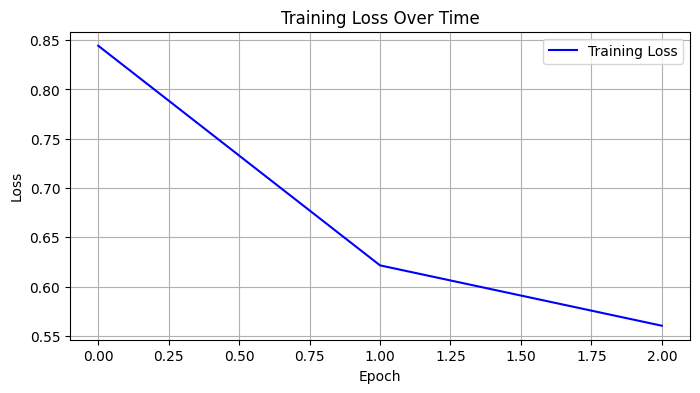


Testing on new examples:
Text: 'Great movie' -> Positive (confidence: 0.667)
Text: 'Bad film' -> Negative (confidence: 0.626)

PRE-TRAINED TRANSFORMER DEMO
Loading pre-trained BERT model...
Extracting embeddings from pre-trained model...
Text 1: 'The weather is beautiful today.'
Embedding shape: torch.Size([1, 8, 768])
First 5 values of [CLS] token: [ 0.24654746 -0.04909667 -0.16375709 -0.21285878 -0.0247433 ]

Text 2: 'I am excited about the new project.'
Embedding shape: torch.Size([1, 10, 768])
First 5 values of [CLS] token: [ 0.16453765  0.0040418   0.09846166 -0.42487288 -0.1262376 ]

Text 3: 'This is a simple example of using transformers.'
Embedding shape: torch.Size([1, 11, 768])
First 5 values of [CLS] token: [-0.24501026 -0.3123978   0.03506605 -0.43452147 -0.43544644]

Using pre-trained pipeline for sentiment analysis...


Device set to use cpu


Text: 'I love this product!'
Sentiment: POSITIVE, Confidence: 1.000

Text: 'This is terrible.'
Sentiment: NEGATIVE, Confidence: 1.000

Text: 'The movie was okay.'
Sentiment: POSITIVE, Confidence: 1.000

Text: 'Absolutely fantastic experience!'
Sentiment: POSITIVE, Confidence: 1.000


Demo completed successfully!


In [13]:
# =============================================================================
# MAIN EXECUTION
# =============================================================================

if __name__ == "__main__":
    print("TRANSFORMER MODEL DEMO")
    print("This demo shows both custom and pre-trained transformer models\n")

    # Install required packages (uncomment if needed)
    # !pip install transformers torch matplotlib numpy

    # Run custom transformer demo
    run_custom_transformer_demo()

    print("\n" + "="*60)

    # Run pre-trained transformer demo
    run_pretrained_transformer_demo()

    print("\nDemo completed successfully!")